In [ ]:
import pandas as pd
import os
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import matplotlib.ticker as mtick
import random

In [ ]:
class Particle:
    def __init__(self, n_stocks):
        self.position =  Particle.initial_swarm(n_stocks)
        self.pbest_position = self.position
        self.pbest_value = -10**3
        self.velocity = np.zeros(n_stocks)

    def move(self):
        proxy = self.position + self.velocity
        proxy = np.where(proxy>1, 1, proxy) # upper bound
        proxy = np.where(proxy<0, 0, proxy) # lower bound
        # print(proxy)
        self.position = proxy/np.sum(proxy)

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights

class Space:
    def __init__(self, n_particles, n_stocks, returns, vol, alpha, w, c1, c2):
        self.n_particles = n_particles
        self.particles = []
        self.gbest_value = -10**3
        self.alpha = alpha #sensitivity to sharpe
        self.n_stocks = n_stocks
        self.gbest_position = Space.initial_swarm(n_stocks)
        self.returns = returns
        self.vol = vol #volatility matrix (variance)
        self.w = w
        self.c1 = c1
        self.c2 = c2

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights

    # fitness function for portfolio optimization
    def fitness(self, particle):
        return_ = np.dot(particle.position, np.transpose(self.returns))
        vol = np.dot(np.dot(particle.position,self.vol), np.transpose(particle.position))
        self.sharpe = return_/np.sqrt(vol)

        # w\cdot covariance\:matrix\times w^{T}
        vols = np.dot(particle.position,self.vol)*particle.position

        # volatility\:dispersion=\sum (stock\:risk\:contibution_{i} -average\:risk)
        self.vol_dis = np.sum(abs(np.sqrt(vols)-np.mean(np.sqrt(vols))))

        # \frac{Sharpe\times\alpha+1 }{volaltility\:dispersion\times(1-\alpha)+1}
        result = (self.sharpe*self.alpha+1)/(self.vol_dis*(1-self.alpha)+1)

        return result

    def set_pbest(self):
        for particle in self.particles:
            fitness_candidate = self.fitness(particle)
            if (particle.pbest_value < fitness_candidate):
                particle.pbest_value = fitness_candidate
                particle.pbest_position = particle.position

    def set_gbest(self):
        for particle in self.particles:
            best_fitness_candidate = self.fitness(particle)
            if(self.gbest_value < best_fitness_candidate):
                self.gbest_value = best_fitness_candidate
                self.gbest_position = particle.position

    def move_particles(self):
        for particle in self.particles:
            new_velocity = (self.w*particle.velocity) + (self.c1*random.random()) * (particle.pbest_position - particle.position) + \
                            (random.random()*self.c2) * (self.gbest_position - particle.position)
            particle.velocity = new_velocity
            particle.move()

In [ ]:
# Largecap Dataset
PATH1 = '/content/SBISENSEX_large.csv'
Largecap = pd.read_csv(PATH1, usecols = ['Date', 'Adj Close'])
Largecap.rename(columns = {'Adj Close':'Largecap'}, inplace= True)
Largecap.reset_index(inplace=True)
Largecap['Date'] = pd.to_datetime(Largecap.Date)
Largecap['Date'] = Largecap['Date'].dt.strftime('%y/%m/%d')

# Midcap Dataset
PATH2 = '/content/Niftymidcap150.csv'
Midcap = pd.read_csv(PATH2, usecols = ['Date', 'Adj Close'])
Midcap.rename(columns = {'Adj Close':'Midcap'}, inplace= True)
Midcap.reset_index(inplace=True)
Midcap['Date'] = pd.to_datetime(Midcap.Date)
Midcap['Date'] = Midcap['Date'].dt.strftime('%y/%m/%d')

# Gold ETF Dataset
PATH3 = '/content/IDBIGOLD_ETF.csv'
gold_etf = pd.read_csv(PATH3, usecols=['Date', 'Adj Close'])
gold_etf.rename(columns={'Adj Close':'gold_etf'}, inplace=True)
gold_etf.reset_index(inplace=True)
gold_etf['Date'] = pd.to_datetime(gold_etf.Date)
gold_etf['Date'] = gold_etf['Date'].dt.strftime('%y/%m/%d')

#Smlcap Dataset
PATH4 = '/content/Niftysml250.csv'
Smlcap = pd.read_csv(PATH4, usecols=['Date', 'Adj Close'])
Smlcap.rename(columns={'Adj Close':'Smlcap'}, inplace=True)
Smlcap.reset_index(inplace=True)
Smlcap['Date'] = pd.to_datetime(Smlcap.Date)
Smlcap['Date'] = Smlcap['Date'].dt.strftime('%y/%m/%d')

portfolio = [Largecap, Midcap, gold_etf, Smlcap]

final = portfolio[0].merge(portfolio[1], how='inner')
final = final.merge(portfolio[2], how='inner')
final = final.merge(portfolio[3], how='inner')
final.drop(labels='index', axis=1, inplace=True)
final.set_index('Date', inplace=True)
final = final.pct_change()
final.dropna(inplace=True)

# Apply mathematical functions and finalize dataset for POS algorithm
df = final
cov_matrix = np.cov(df, rowvar=False) * df.shape[0]
returns = (df+1).cumprod(axis=0).iloc[-1,:].values-1

In [ ]:
df.head()

,Largecap,Midcap,gold_etf,Smlcap
Date,,,,
17/11/14,-0.003857,-0.002810,-0.039517,-0.001995
17/11/15,-0.008174,-0.010764,0.000000,-0.016104
17/11/16,0.003470,0.011785,0.000000,0.010463
17/11/17,0.018732,0.008624,0.000000,0.008178
17/11/20,-0.001414,0.006572,0.010418,0.008850


In [ ]:
dic_pos = {}
best_values, sharpes, disp = [], [], []
n_count = len(portfolio)

for a in range(0,100,1):
    alpha = a/100
    search_space = Space(50, n_count, returns, cov_matrix, alpha, w=0.72984, c1=2.05, c2=2.05)
    particles_vector = [Particle(search_space.n_stocks) for _ in range(search_space.n_particles)]
    search_space.particles = particles_vector
    n_iterations = 1000
        # algo
    iteration = 0
    prev_gbest_value = -10**4
    while(iteration < n_iterations):
        search_space.set_pbest()
        search_space.set_gbest()

        if(abs(search_space.gbest_value - prev_gbest_value) < 0.0001) and (iteration>3):
            break
        prev_gbest_value = search_space.gbest_value
        print('Iteration: {0} Position {1}, Value: {2:.3f}'.format(iteration,
                                                                search_space.gbest_position, search_space.gbest_value))
        search_space.move_particles()
        iteration += 1
    print('finished {} ---------'.format(alpha))

    best_values.append(search_space.gbest_value)
    sharpes.append(search_space.sharpe)
    disp.append(search_space.vol_dis)
    dic_pos[a] = search_space.gbest_position

<ipython-input-3-99ef2c02c0e8>:51: RuntimeWarning: invalid value encountered in sqrt
  self.vol_dis = np.sum(abs(np.sqrt(vols)-np.mean(np.sqrt(vols))))


Iteration: 0 Position [0.27991625 0.22353311 0.31242251 0.18412814], Value: 0.996
Iteration: 1 Position [0.27684334 0.22183284 0.31197849 0.18934533], Value: 0.996
Iteration: 2 Position [0.27871534 0.22042398 0.3133208  0.18753988], Value: 0.996
Iteration: 3 Position [0.26559719 0.23397067 0.31379293 0.18663921], Value: 0.997
finished 0.0 ---------
Iteration: 0 Position [0.28164508 0.21903484 0.29893351 0.20038657], Value: 0.994
Iteration: 1 Position [0.27764041 0.22207869 0.30441273 0.19586817], Value: 0.998
Iteration: 2 Position [0.28039604 0.20676815 0.31646727 0.19636854], Value: 0.999
Iteration: 3 Position [0.27585949 0.22141736 0.30926212 0.19346104], Value: 1.000
Iteration: 4 Position [0.27422577 0.22118851 0.31325828 0.19132745], Value: 1.002
Iteration: 5 Position [0.27303342 0.22102148 0.31617484 0.18977027], Value: 1.004
Iteration: 6 Position [0.27300677 0.22566295 0.31678712 0.18454316], Value: 1.004
Iteration: 7 Position [0.27332038 0.22485407 0.31591956 0.18590599], Value:

In [ ]:
a = np.array(list(dic_pos.values()))
Largecap = a[:,0]
Midcap = a[:,1]
gold_etf = a[:,2]
Smlcap = a[:, 3]

portfolio = [Largecap, Midcap, gold_etf, Smlcap]
portfolio_sf = [savgol_filter(i, 7, 3) for i in portfolio]
total_sf = np.array(portfolio_sf)
total = np.array(portfolio)

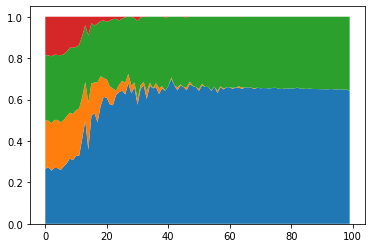

In [ ]:
%matplotlib inline
plt.stackplot(range(0,100), total, labels=['Largecap']);

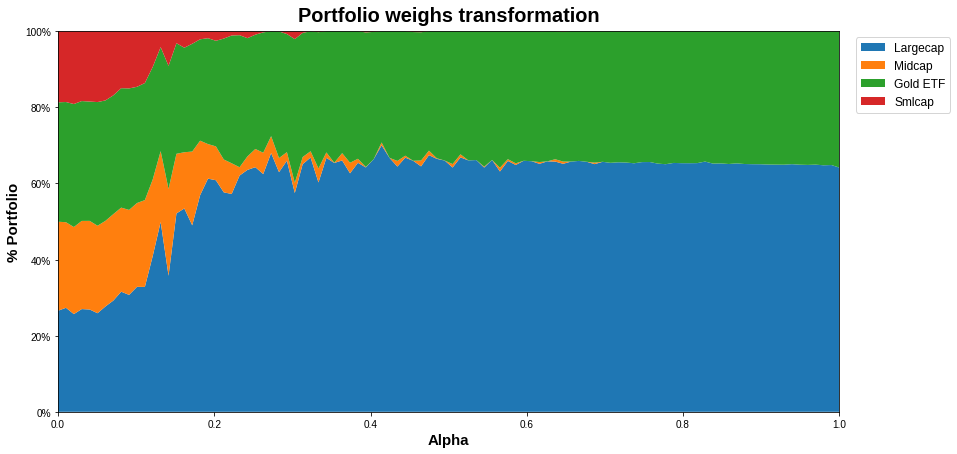

In [ ]:
fig = plt.figure(1, (14,7))
ax = fig.add_subplot(1,1,1)

ax.stackplot(np.linspace(0,1,100), total*100, labels=['Largecap', 'Midcap', 'Gold ETF', 'Smlcap'])
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1, fontsize=12)
plt.xlabel('Alpha', fontsize=15, fontweight='semibold')
plt.ylabel('% Portfolio', fontsize=15, fontweight='semibold')

fmt = '%.0f%%' # Format for the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.margins(0)
plt.title('Portfolio weighs transformation', pad=10, fontsize=20, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.savefig('portfolio_weighs_transformation.png')
plt.show()

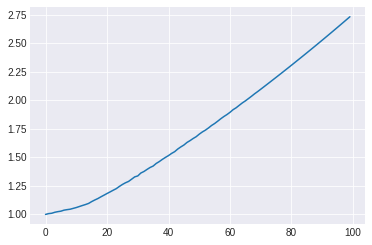

In [ ]:
# need to calculate sharpe ratio and
plt.plot(best_values)

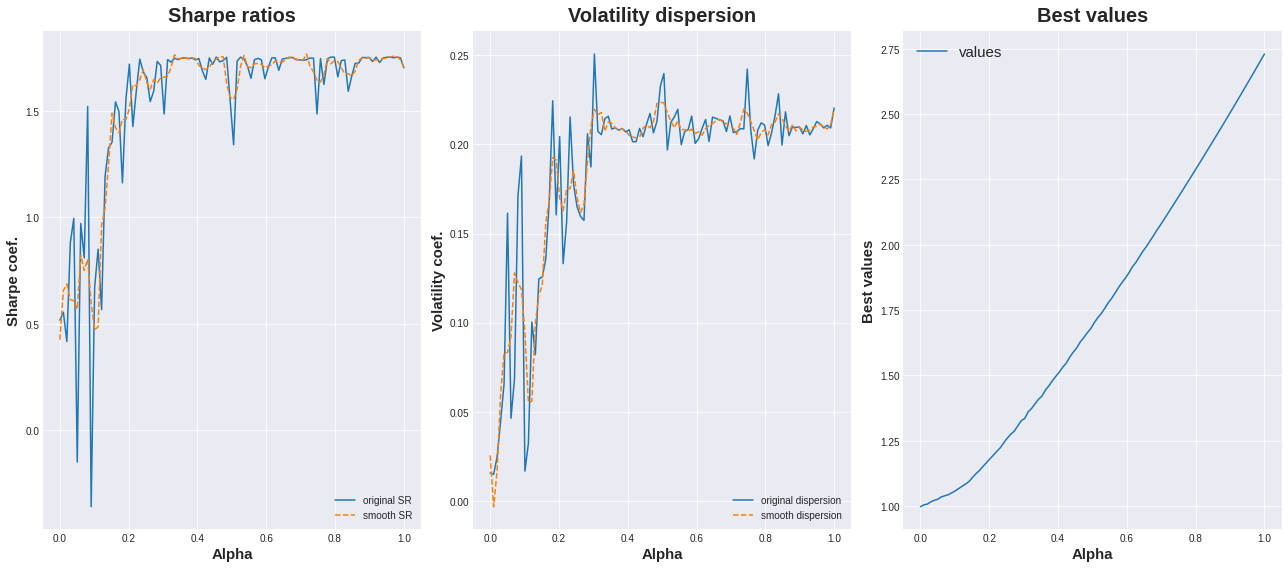

In [ ]:
# Several graphs
fig = plt.figure(1,(18,8))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# Sharpe
ax1.plot(np.linspace(0,1,100), sharpes, label='original SR')
ax1.plot(np.linspace(0,1,100), savgol_filter(sharpes, 7, 3), linestyle ='--', label='smooth SR')
ax1.legend(loc='best')
ax1.set_xlabel('Alpha', fontsize=15, fontweight='semibold')
ax1.set_ylabel('Sharpe coef.', fontsize=15, fontweight='semibold')
ax1.set_title('Sharpe ratios', pad = 10, fontsize=20, fontweight='bold')

# Vol dispersion
ax2.plot(np.linspace(0,1,100), disp, label='original dispersion')
ax2.plot(np.linspace(0,1,100), savgol_filter(disp, 7, 3), linestyle ='--', label='smooth dispersion')
ax2.legend(loc='best')
ax2.set_xlabel('Alpha', fontsize=15, fontweight='semibold')
ax2.set_ylabel('Volatility coef.', fontsize=15, fontweight='semibold')
ax2.set_title('Volatility dispersion', pad = 10, fontsize=20, fontweight='bold')

# optimization coef.
ax3.plot(np.linspace(0,1,100), best_values, label = 'values')
ax3.legend(loc='best', fontsize=15)
ax3.set_xlabel('Alpha', fontsize=15, fontweight='semibold')
ax3.set_ylabel('Best values', fontsize=15, fontweight='semibold')
ax3.set_title('Best values', pad = 10, fontsize=20, fontweight='bold')

plt.tight_layout()
plt.style.use('seaborn-darkgrid')
plt.savefig('Multiplot.png')
plt.show()

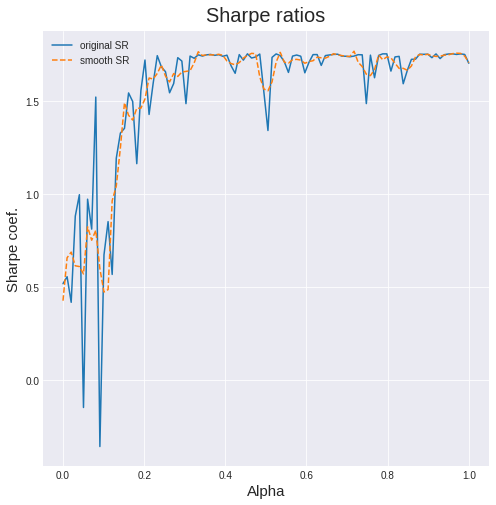

In [ ]:
# Sharpe
fig = plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100), sharpes, label='original SR')
plt.plot(np.linspace(0,1,100), savgol_filter(sharpes, 7, 3), linestyle ='--', label='smooth SR')
plt.legend(loc='upper left')
plt.xlabel('Alpha', fontsize=15)
plt.ylabel('Sharpe coef.', fontsize=15)
plt.title('Sharpe ratios', pad = 10, fontsize=20)
plt.savefig('sharpe_ratio.png')
plt.show()

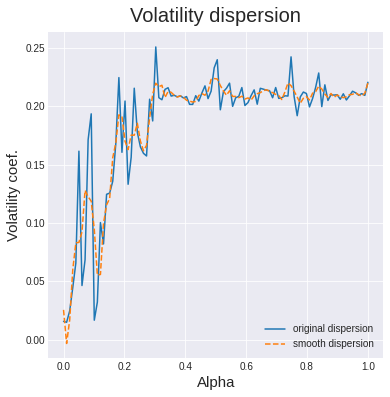

In [ ]:
# Vol dispersion
fig = plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,1,100), disp, label='original dispersion')
plt.plot(np.linspace(0,1,100), savgol_filter(disp, 7, 3), linestyle ='--', label='smooth dispersion')
plt.legend(loc='lower right')
plt.xlabel('Alpha', fontsize=15)
plt.ylabel('Volatility coef.', fontsize=15)
plt.title('Volatility dispersion', pad = 10, fontsize=20)
plt.savefig('volatility_dispersion.png')
plt.show()

# plt.tight_layout()
# plt.style.use('seaborn-darkgrid')
# plt.show()

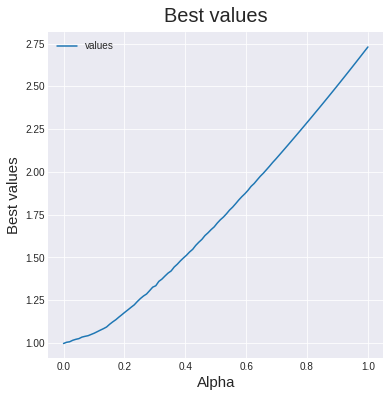

In [ ]:
# optimization coef.
fig = plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,1,100), best_values, label = 'values')
plt.legend(loc='best')
plt.xlabel('Alpha', fontsize=15)
plt.ylabel('Best values', fontsize=15)
plt.title('Best values', pad = 10, fontsize=20)
plt.show()

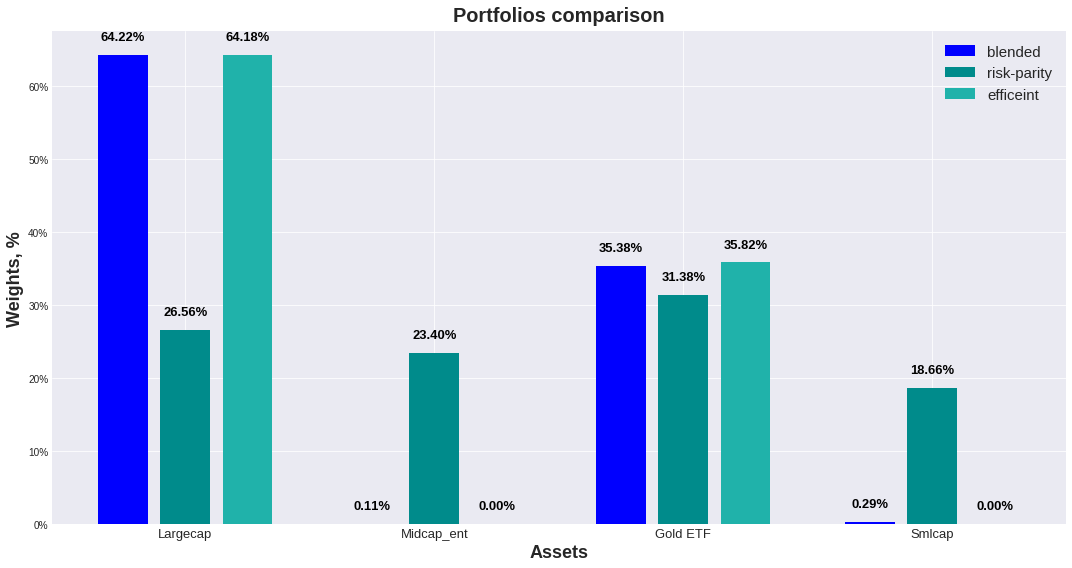

In [ ]:
pos = [1, 5, 9, 13]

fig = plt.figure(1,(15,8))
ax = fig.add_subplot(1,1,1)
_ = ax.bar(pos, total[:,39]*100, color='blue', label='blended')

for i,v in zip(pos, total[:,39]*100):
    ax.text(i, v+2, "{:.2f}%".format(v), ha ='center', color = 'black', fontsize = 13, fontweight='semibold')

_ = ax.bar([i+1 for i in pos], total[:,0]*100, color='darkcyan', label='risk-parity')

for i,v in zip([i+1 for i in pos], total[:,0]*100):
    ax.text(i, v+2, "{:.2f}%".format(v), ha ='center', color = 'black', fontsize = 13, fontweight='semibold')

_ = ax.bar([i+2 for i in pos], total[:,-1]*100, color = 'lightseagreen', label = 'efficeint')

for i,v in zip([i+2 for i in pos], total[:,-1]*100):
    ax.text(i, v+2, "{:.2f}%".format(v), ha ='center', color = 'black', fontsize = 13, fontweight='semibold')

ax.set_xticks([i+1 for i in pos])
ax.set_xticklabels(('Largecap','Midcap_ent', 'Gold ETF', 'Smlcap'), fontsize = 13)
ax.set_xlabel('Assets', fontsize=18, fontweight='semibold')

fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_ylabel('Weights, %', fontsize = 18, fontweight='semibold')

ax.legend(loc='best', fontsize=15)
ax.set_title('Portfolios comparison', pad = 10, fontsize=20, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.tight_layout()
plt.savefig('portfolio_comparision.png')
plt.show()